In [1]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics # limited set of methods included in Julia Base
using StatsBase  # extends Statistics with more functions
using Rotations
using FFTW
# using SignalAlignment
using Interpolations
using PyPlot
using JLD2
# using MAT

include("./readers.jl")
using .ShipPosmv

include("./read_lidar.jl")
using .read_vecnav: read_vecnav_dict

include("./timing_lidar.jl")
using .timing_lidar

  Activating project at `~/Projects/ASTRAL/lidar`


In [2]:
# helper functions
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x

anom(x; dims=1) = x .- mean(x; dims=dims)

# functional wrapper for PyPlot plot
plotf(f::Function, x, va...) = plot(x, f.(x), va...)

plotf (generic function with 1 method)

In [3]:
# rotations example

# RotXY(roll, pitch) # radians
# matrix that rotates around y (pitch), then by x (roll) in radians
RotXY(10/180*pi, 5/180*pi)

3×3 RotXY{Float64} with indices SOneTo(3)×SOneTo(3)(0.174533, 0.0872665):
  0.996195   0.0        0.0871557
  0.0151344  0.984808  -0.172987
 -0.0858317  0.173648   0.98106

In [4]:
# The Vn was rotated (Z) relative to the coordinates of the ship. The gimbal was aligned with the ship.
# To rotate Vn coordinate into POSMV coordinate due to this Z rotation
VNpr = RotZ(20/180*pi)[1:2,1:2] * vcat(pd(Vn[:Roll]*pi/180), pd(Vn[:Pitch]*pi/180))
# This might work, but maybe not well because the roll gimbal "stabilized" assuming
# Vn was aligned with pitch and roll gimbals, not rotated ~20 degrees.
# There are times when roll stabilization was poor.

UndefVarError: UndefVarError: `Vn` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Use `RotXY(ϕ, θ)` when there is no stabilization; i.e., the lidar is strapped down to the deck, as in the first part of EKAMSAT leg 2.


In the second part of EKAMSAT leg 2, the stabilization was working only for the roll axis.
The pitch axis was strapped, so we can synchronize using the pitch angle as in `vectornav.ipynb`.
To start, assume the pitch gimbal is strapped level to the ship deck (there might be a small offset angle).
If the roll stabilization works well, then the lidar coordinate system is rotated only by the pitch angle about the y axis.
Use `RotY(θ)` for this rotation matrix.

For leg 1 we assume it's fully stabilized, so we can measure the difference between the heave at the lidar and at the POSMV.
The heave measured by the POSMV is assumed to be vertical, and the heave at the VectorNav on the lidar, is also vertical when stabilized.
In this case, the displacement moments $(L_x, L_y, L_z)$ between the lidar and the POSMV are responsible for the difference in heave vertical velocity at the lidar $w$ compared to the POSMV $w_0$,
$$
w' = w - w_0 = A\theta + B\phi,\\
A = (L_x^2 + L_z^2)^{1/2},\\
B = (L_y^2 + L_z^2)^{1/2}
$$
where $\theta$ is the pitch and $\phi$ is the roll. This is a regression problem for ${\bf a} = [A; B]$, given $w'$ and $v=[\theta; \phi]$.

$$
{\bf w'} = {\bf av}\\
{\bf a} = {\bf w'}{\bf v}^{-1} = {\bf v}\backslash {\bf w'}.
$$

The rotations and angular rates are each in different coordinate systems. 
It is convenient to add velocity vectors in the pitched (but not rolled) coordinate system, denoted by a prime ($'$).
The lidar is in pitched and rolled coordinate system denoted by double-prime ($''$).
The velocity vector in the pitched coordinate is
$$
{\bf u}' =  {\bf u}_p' + {\bf u}_r' + {\bf w}'_0,\\
{\bf w}'_0 = {\bf R}_\theta{\bf w}_0 = {\bf R}_\theta(0,0,w_0),\\
{\bf u}_p' = {\bf R}_\theta {\bf u}_p = {\bf R}_\theta\dot{\theta}(-L_z,0,L_x),\\
{\bf u}_r' = \dot\phi(0, L_z,-L_y).
$$
In the lidar coordinate system,
$$
{\bf u}'' = {\bf R}_\phi{\bf u}'.
$$
When strapped down, the VectorNav measures one component of ${\bf u}''$, nominally the component in the upward $z$-direction.


In leg 2 part 2 the pitch stabilization gimbal failed
and was strapped down, but the roll stabilization continued. 
For this time, we synchronize the POSMV and VectorNav 
time using the unstabilized pitch angle, and then regress for coefficients
that explain the observed platform velocity in the lidar frame from
rotations about the POSMV.


### Procedure
1. Read POSMV and VectorNav data.
2. Synchronize time in 2-10 min windows.
    - Using POSMV pitch and VectorNav roll for leg 2, part 2,
    Vectornav `vndt` (GPS, 20 Hz ) and 
    POSMV `posmvdt`(UTC, 2 Hz) are synchronized, 
    taking into account
    the 18 GPS leapseconds.
3. Regress pitch and roll angles on heave to get moments $L_x, Ly, Lz$.

Vectornav `vndt` (GPS, 20 Hz ) and 
POSMV `posmvdt`(UTC, 2 Hz) are synchronized, 
taking into account
the 18 GPS leapseconds.

In [5]:
# differentiate POSMV angles to get angular rates
# and heave to get vertical velocity
dt = 0.5 # sampling interval

"derivative by FFT, assuming sampling rate of 1."
function fft_derivative(f::AbstractVector{T}) where T <: Real
    N = length(f) 
    k = collect(fftfreq( N )) * 2π  # angular frequencies (wavenumbers)
    # for even N exclude Nyquist frequency according to SG Johnson
    # https://math.mit.edu/~stevenj/fft-deriv.pdf
    if iseven(N)
        k[Integer(N/2)] = 0
    end
    F_deriv = 1im * k .* fft(f)    # multiply FFT by i*k in the frequency domain
    return real( ifft(F_deriv) )     # inverse FFT to get the derivative in time domain
end# taper the ends with an n-point quarter sine^2 wave taper

"taper for conditioning the ends of time series"
taper(n) = @. sin( π/2 * (0:n-1)/n )^2
f_taper(f,n) = [f[1:n].*taper(n); f[n+1:end-n]; f[end-n+1:end].*reverse(taper(n))]
"tapering method"
fft_derivative(f; taper=8) = fft_derivative(f_taper(f,taper))

#= deprecated
# raw"the angle- and angular-rate coefficient vector V of L = V\w"
# function V_angles(θ, ϕ, θrate=fft_derivative(θ)/dt, ϕrate=fft_derivative(ϕ)/dt)
#     v1 = @. θrate*cos(ϕ)*cos(θ)
#     v2 = @. ϕrate*cos(ϕ)
#     v3 = @. ϕrate*sin(ϕ) + θrate*cos(ϕ)*sin(θ)
#     return [v1, v2, v3] # vector
# end

# BUT heave w_lidar at the lidar is measured in the vertical coordinate,
# NOT a tilted coordinate, so ϕ,θ should be taken to be 0, but rates may be nonzero.

# redo: cosϕ=cosθ=1, sinϕ=sinθ=0
raw"the angle- and angular-rate coefficient vector V of L = V\w"
V_vert_angles(θrate, ϕrate) = [θrate, ϕrate, 0] # 3-vector

# L = [θrate, ϕrate, 0] \ (w_lidar - w_ship)
=#

function angle_vec(θ, ϕ, θrate, ϕrate)
    ctcp = cos(θ)*cos(ϕ)
    [-θrate*ctcp, ϕrate*ctcp, θrate*sin(θ)-ϕrate*cos(θ)*sin(θ)]
end

"solve for moments L by regression"
solve_L(w, M) = M \ anom(w, dims=1) 
#              3xn               nx1

# Use ABSOLUTE angles for rotation matrices
# Rates are derivatives so probably already don't have mean offsets.
# Maybe use anomalies for velocities

solve_L

In [6]:
# read data

Vn = read_vecnav_dict()
Pashr = Dict(Symbol(key) => value for (key, value) in load("./data/table/ASTraL_POSMV.jld2"))

ϕ = Pashr[:roll]  * pi/180 # -> radians
θ = Pashr[:pitch] * pi/180
# heave_ship = Pashr[:heave] # positive down DISPLACEMENT
w_lidar = Vn[:VelNED2] # positive down

# time coordinates
# posmvdt = Pashr[:posmvdt] # UTC convention
posmvdt = Pashr[:time] # UTC convention # is correction doing more harm than good?
vndt = Vn[:vndt]          # GPS convention

42870733-element Vector{DateTime}:
 2024-04-29T05:25:42.128
 2024-04-29T05:25:42.178
 2024-04-29T05:25:42.228
 2024-04-29T05:25:42.278
 2024-04-29T05:25:42.328
 2024-04-29T05:25:42.378
 2024-04-29T05:25:42.428
 2024-04-29T05:25:42.478
 2024-04-29T05:25:42.528
 2024-04-29T05:25:42.578
 ⋮
 2024-06-10T23:25:22.372
 2024-06-10T23:25:22.422
 2024-06-10T23:25:22.472
 2024-06-10T23:25:22.522
 2024-06-10T23:25:22.572
 2024-06-10T23:25:22.622
 2024-06-10T23:25:22.672
 2024-06-10T23:25:22.722
 2024-06-10T23:25:22.772

In [7]:
# derivatives
θrate=fft_derivative(θ, taper=10)/dt
ϕrate=fft_derivative(ϕ, taper=10)/dt
w_posmv = fft_derivative(Pashr[:heave], taper=10)/dt # m/s

6898538-element Vector{Float64}:
  0.003909277310197009
  0.006766737850326435
 -0.01178983754212335
 -0.0747615408797153
 -0.1532592001624441
 -0.25597143876155226
 -0.3168760825991297
 -0.2781186425265391
 -0.08109306635305728
  0.1385182397152679
  ⋮
  0.19321182097837236
  0.09999273760411034
 -0.05419707895165979
 -0.1636827118982359
 -0.1434694929541529
 -0.028908905129056677
  0.05865073458941531
  0.06342750112677566
  0.005472302341533565

In [ ]:
# plot previous iteration of time coordinate
clf()
plot(Pashr[:posmvdt][1:60:end], Dates.value.(Pashr[:time][1:60:end].-Pashr[:posmvdt][1:60:end]))
# plot(Vn[:vndt][1:60:end], Dates.value.(Vn[:time][1:60:end].-Vn[:vndt][1:60:end] ))
gcf()
# Pashr[:gpstime][1:3],Pashr[:posmvdt][1]
# Pashr[:gpstime]
# Vn[:GpsTime]

42870733-element Vector{Int64}:
 1398403542128282112
 1398403542165782016
 1398403542234532096
 1398403542278281984
 1398403542340781824
 1398403542372032000
 1398403542440782080
 1398403542484532224
 1398403542528281856
 1398403542590781952
                   ⋮
 1402097122311875072
 1402097122361874944
 1402097122411875072
 1402097122474374912
 1402097122518125056
 1402097122561875200
 1402097122611875072
 1402097122668129024
 1402097122711875072

Window the data in ~1 min sections and sync the time coordinates.

In [ ]:
# Explore VN time coordinates

Vn[:vndt][1] # 2024-04-29T05:25:42.128

igap = findall(diff(Vn[:vndt]) .> Minute(1))[1] # one gap
# n[:vndt][[1, igap.+[0, 1], length(Vn[:vndt])]]
ise = [1, igap, igap+1, length(Vn[:vndt])]
clf()
plot(Vn[:vndt][ise], marker=".", linestyle="none")
gcf()
Vn[:vndt][ise]
#=
VectorNav leg 1
2024-04-29T05:25:42.128
2024-05-14T10:00:32.927
VectorNav leg 2
2024-06-01T04:18:42.098
2024-06-10T23:25:22.772
=#

# Explore POSMV computer time coordinate
igap = findall(diff(Pashr[:posmvdt]) .> Minute(1))[1] # one gap
isp = [1, igap, igap+1, length(Pashr[:posmvdt])]
Pashr[:posmvdt][isp]
#=
POSMV leg 1
2024-04-30T00:00:01.868
2024-05-13T13:43:50.852
POSMV leg 2
2024-05-17T22:53:24.908
2024-06-13T07:17:40.050
=#

4-element Vector{DateTime}:
 2024-04-30T00:00:01.868
 2024-05-13T13:43:50.852
 2024-05-17T22:53:24.908
 2024-06-13T07:17:40.050

In [ ]:
# Explore PASHR GPS time
pgdt = timing_lidar.pashr_gps_datetime.(Pashr[:time], Pashr[:gpstime])
DVS(timedelta) = Dates.value(Millisecond(timedelta)) / 1000
# clf()
# plot(pgdt[2:end], DVS.(diff(pgdt)))
# ylim([-5, 5])
# gcf()

length(pgdt)-1, # count = 6898537
sum(DVS.(diff(pgdt)).<0.5), # 0
sum(DVS.(diff(pgdt)).==0.5), # 6869355
sum(0.5 .< DVS.(diff(pgdt)) .< 1.0), # 29169
sum(DVS.(diff(pgdt)) .== 0.501), # 29167
sum(DVS.(diff(pgdt)) .== 0.505), # 2
sum(DVS.(diff(pgdt)).== 1.0), # 11
sum(DVS.(diff(pgdt)).> 1.0) # 2 : leg1-2 gap, one 1.001 gap
# 6869355 + 29169 + 11 + 2 == 6898537
# so this accounts for all time deltas

# sum(DVS.(diff(pgdt)).==1.0) # 11
# DVS.(diff(pgdt))[DVS.(diff(pgdt)).> 1.0] # leg1-2 gap, one 1.001 gap
# DVS.(diff(pgdt))[0.5 .< DVS.(diff(pgdt)) .< 1.0] # leg1-2 gap, one 1.001 gap
# DVS.(diff(pgdt))[(0.5 .< DVS.(diff(pgdt)) .< 1.0) .& .!(DVS.(diff(pgdt)) .== 0.501)] # leg1-2 gap, one 1.001 gap

# The POSMV GPS time does not seem to be resetting. 
# It's highly regular at dt=0.5 s; 0.4% (29167) dt=0.501; 2 steps of dt=0.505;
# 12 timesteps are skipped giving dt=1.00[1];
# and there's the several day leg 1 - leg 2 gap.

# Rather, it must be the POSMV computer clock that is resetting and recorded with more jitter.
# Hence, use the POSMV GPS time: 
# pgdt = timing_lidar.pashr_gps_datetime.(Pashr[:time], Pashr[:gpstime])

daylimits (generic function with 8 methods)

In [ ]:
# deprecated # window time series with time axes

# "posmv and vectornav indices for requested UTC DateTime start and epoch length TimePeriod"
# function daylimits(utcdt::DateTime=DateTime(2024,6,1,6,0,0), epoch::Period=Minute(3), leapseconds=18)
#     post = findfirst( posmvdt .>= utcdt )
#     poen = findlast(  posmvdt .<= utcdt + epoch )
#     vnst = findfirst( vndt    .>= utcdt + Second(leapseconds) ) # view +18 leapseconds forward to agree with UTC
#     vnen = findlast(  vndt    .<= utcdt + Second(leapseconds) + epoch )
#     post, poen, vnst, vnen
# end

In [ ]:
# window time series with time axes
"""
posmv and vectornav indices for requested UTC DateTime start and epoch length TimePeriod
daylimits(posmvdt, vndt, utcdt::DateTime=DateTime(2024,6,1,6,0,0), epoch::Period=Minute(3), leapseconds=18)
"""
function daylimits(posmvdt, vndt, utcdt::DateTime=DateTime(2024,6,1,6,0,0), epoch::Period=Minute(3), leapseconds=18)
    post = findfirst( posmvdt .>= utcdt )
    poen = findlast(  posmvdt .<= utcdt + epoch )
    vnst = findfirst( vndt    .>= utcdt + Second(leapseconds) ) # view +18 leapseconds forward to agree with UTC
    vnen = findlast(  vndt    .<= utcdt + Second(leapseconds) + epoch )
    post, poen, vnst, vnen
end

# time coordinates
# posmvdt = Pashr[:posmvdt] # UTC convention
# REPLACE posmvdt with POSMV GPS time, which is probably more reliable :: 2025 Feb 12
posmvdt = timing_lidar.pashr_gps_datetime.(Pashr[:time], Pashr[:gpstime]) # UTC convention
# posmvdt = Pashr[:time] # UTC convention 
# is correction doing more harm than good?
# Both the corrected and original have offsets
vndt = Vn[:vndt]          # GPS convention

# indices of unique types of gaps
idrop =  findall( Millisecond(680) .< diff(posmvdt) .< Second(2) )
ireset = findall( Second(2)        .< diff(posmvdt) .< Hour(1) )
ileg =   findall( Hour(1)          .< diff(posmvdt)  )
# findall(diff(posmvdt) .< Millisecond(0)) # none

length(idrop), length(ireset), length(ileg), length(pmvdt), length(posmvdt)
diff(posmvdt)[idrop] # 1000 ± 16 ms
diff(posmvdt)[ireset] # 2600, 3200, 3300, 3800, 4500 ms
# posmvdt1 = posmvdt[1]:Millisecond(500):posmvdt[igap]
# posmvdt2 = posmvdt[igap+1]:Millisecond(500):posmvdt[end]
# pmvdt = vcat(posmvdt1,posmvdt2)
# diff(posmvdt)[idrop]

4.6296296296296294e-5

In [ ]:
# set the default daylimits method to use POSMV GPS time pgdt
daylimits(utcdt::DateTime=DateTime(2024,6,1,6,0,0), epoch::Period=Minute(3), leapseconds=18) =
    daylimits(pgdt, vndt, utcdt, epoch, leapseconds)

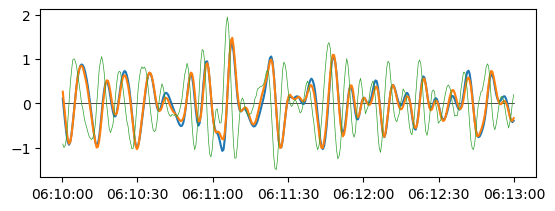

In [10]:
# sync time series

sample_factor = 9.94 #9.933333 # 9.95 not quite 10 = 20 Hz / 2 Hz
# Vn actually samples slightly slower than 10x the speed of POSMV
# so stepping by 10 Vn gets ahead of alignment with POSMV.
# Need to advance one index less (9 rather than 10) every 167 samples

# example time series synced by hand in vectornav.ipynb
post, poen, vnst, vnen = daylimits(DateTime(2024,6,1,6,10,0), Minute(3)) # June 1 1st day of Vn2
# this example window has a lag of ~20 s (`vectornav.ipynb`) 
# subtract 20 s from vndt to match same signal at same time
# indices vnst:vnen already shift for the 18 GPS leapseconds;
# at this time, need to shift forward 40 indices for the 2 s.
vn_offset = 60
# indices for Vn that line up with POSMV
vv = round.(Integer, range(vn_offset+vnst, step=sample_factor, length=poen-post+1))
pp = post:poen
# plot demonstrates that it's synced
clf()
subplot(2,1,1)
plot(posmvdt[[post, poen]], [0,0], color="k", linewidth=0.5)
plot(posmvdt[post:poen], anom(Pashr[:pitch][post:poen]), label="POSMV pitch") # blue
plot(posmvdt[post:poen], anom(Vn[:Roll][vv]), label="VectorNav roll")
plot(posmvdt[post:poen], 100.0 .*θrate[post:poen], label="rate", linewidth=0.5)
# plot(posmvdt[post:poen], 100.0 .*anom(θrate[post:poen]), label="rate")
gcf()

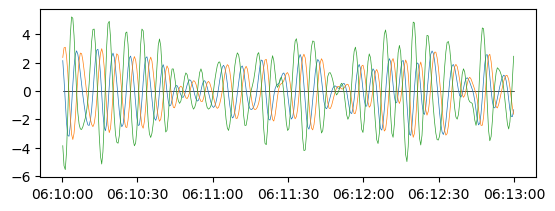

In [12]:
# window and sync time series

# example time series synced by hand in vectornav.ipynb
post, poen, vnst, vnen = daylimits(DateTime(2024,6,5,6,10,0), Minute(3), 18) # June 1 1st day of Vn2
vn_offset = +30
# VN time offset = leapseconds + vn_offset/20 seconds
post, poen, vnst, vnen = daylimits(DateTime(2024,6,10,6,10,0), Minute(3), 18) # June 1 1st day of Vn2
vn_offset = -18
# this example window has a lag of ~20 s (`vectornav.ipynb`) 
# subtract 20 s from vndt to match same signal at same time
# indices vnst:vnen already shift for the 18 GPS leapseconds;
# at this time, need to shift forward 40 indices for the 2 s.

# indices for Vn that line up with POSMV - same as above cell
vv = round.(Integer, range(vn_offset+vnst, step=sample_factor, length=poen-post+1))
pp = post:poen
# plot demonstrates that it's synced
# this diagnostic is different than shifting the time as in vectornav.ipynb
clf()
subplot(2,1,1)
plot(posmvdt[[post, poen]], [0,0], color="k", linewidth=0.5)
plot(posmvdt[post:poen], anom(Pashr[:pitch][post:poen]), label="POSMV pitch", linewidth=0.5) # blue
plot(posmvdt[post:poen], anom(Vn[:Roll][vv]), label="VectorNav roll", linewidth=0.5)
# plot(posmvdt[post:poen], 100.0 .*θrate[post:poen], label="rate", linewidth=0.5)
plot(posmvdt[post:poen], 100.0 .*anom(θrate[post:poen]), label="rate", linewidth=0.5)
gcf()

# timing drifts over 3 min from 6-10 6:10 to 6:13

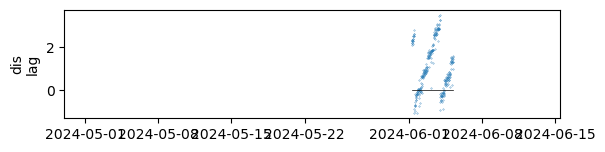

In [13]:
# test automatic lag finding

factor = 10        # hi/lo sample rate
epoch_length = 480 # lo-freq samples, 4 min windows
initial_guess = 0
window = 90
wideoffset = 4 # s
start_idx = 2*wideoffset # corresp to ±4 s possible offsets 

# calculate lag every 10 min
dts = (DateTime(2024,6,1,6,0,)-Second(wideoffset)):Minute(20):(DateTime(2024,6,5,6,0,0)+Second(wideoffset))

optlag = zeros(Int32, length(dts))
for (i, dt) in enumerate(dts)
    (post, poen, vnst, vnen) = daylimits(dt, Minute(5)) # 5 m window epoch
    low_freq_series = Pashr[:pitch][post:poen]
    high_freq_series = Vn[:Roll][vnst:vnen]
    initial_guess = grid_search(high_freq_series, low_freq_series, factor, start_idx, epoch_length, initial_guess, window)
    optlag[i] = initial_guess
end

optlag # clearly works

clf()
subplot(3,1,1)
plot(dts, 0.05*optlag, marker=".", markersize=0.5, linestyle="none")
plot([dts[1], dts[end]], [0,0], color="k", linewidth=0.5)
xlim([DateTime(2024,4,29), DateTime(2024,6,15,12)])
ylabel("dis\nlag")
gcf()

In [15]:
sample_factor = 10        # hi/lo sample rate
epoch_length = 120 # lo-freq samples, 2 min windows
initial_guess = 0
window = 90
wideoffset = 4 # s
start_idx = 2*wideoffset # corresp to ±4 s possible offsets 

#=
VectorNav leg 1
2024-04-29T05:25:42.128
2024-05-14T10:00:32.927
VectorNav leg 2
2024-06-01T04:18:42.098
2024-06-10T23:25:22.772
POSMV leg 1
2024-04-30T00:00:01.868
2024-05-13T13:43:50.852
POSMV leg 2
2024-05-17T22:53:24.908
2024-06-13T07:17:40.050
=#

# calculate lag every 1 min for both legs 1 and 2
dts1 = (DateTime(2024, 4,30, 0,10,0)-Second(wideoffset)):Minute(60):(DateTime(2024, 5,13,13,40,0)+Second(wideoffset))
dts2 = (DateTime(2024, 6, 1, 4,20,0)-Second(wideoffset)):Minute(60):(DateTime(2024, 6,10,23,20,0)+Second(wideoffset))
dts = vcat(dts1, dts2)
optlag = zeros(Int32, length(dts))

# (post, poen, vnst, vnen) = daylimits(dts[i], Second(90)) # must be > epoch_length/2 ?
#     optlag[i] = grid_search(Vn[:Roll][vnst:vnen], Pashr[:pitch][post:poen], 
#         sample_factor, start_idx, epoch_length, initial_guess, window)

for (i, dt) in enumerate(dts)
    (post, poen, vnst, vnen) = daylimits(dt, Second(90)) # must be > epoch_length/2 ?
    optlag[i] = grid_search(Vn[:Roll][vnst:vnen], Pashr[:pitch][post:poen], 
        sample_factor, start_idx, epoch_length, initial_guess, window)
    initial_guess = round(Int32, optlag[i] / 2)
end

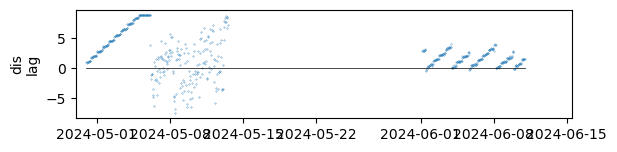

In [16]:
clf()
subplot(3,1,1)
plot(dts, 0.05*optlag, marker=".", markersize=0.5, linestyle="none")
plot([dts[1], dts[end]], [0,0], color="k", linewidth=0.5)
xlim([DateTime(2024,4,29), DateTime(2024,6,15,12)])
ylabel("dis\nlag")
gcf()

This is ~equal and opposite the POSMV-GPS difference, suggesting that correcting the POSMV to the GPS clock is doing more harm than good.

Want the lag between POSMV to be close to constant. Some jitter OK, but not secular drifts.

In [105]:
# postmortem of lag finding
clf()
plot(dts,optlag)
gcf()
i = findfirst(optlag.==0) # where it stopped
dt = dts[i]
i, dt, dts[i+1]
(post, poen, vnst, vnen) = daylimits(dt, Second(90))
any(ismissing.(Vn[:Roll][vnst:vnen])) # none
any(ismissing.(Pashr[:pitch][post:poen])) # none
optlag[i.+(-2:2)] 
initial_guess=0
initial_guess = grid_search(Vn[:Roll][vnst:vnen], Pashr[:pitch][post:poen], 
        sample_factor, start_idx, epoch_length, initial_guess, window)
# optlag and initial_guess drifted up and out if the valid range of the window

90

In [ ]:
D = Dict(:dt_minute => dts , :VN_idx_offset => optlag)

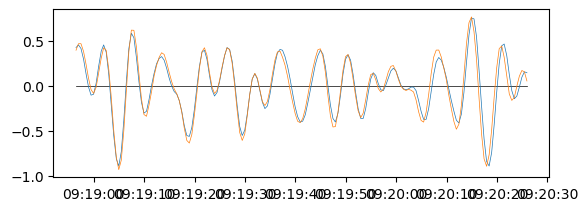

In [44]:
# test plot one minute
i = 200
(post, poen, vnst, vnen) = daylimits(dts[i], Second(90))
vv = round.(Integer, range(optlag[i]+vnst, step=sample_factor, length=poen-post+1))

# plot demonstrates that it's synced
# this diagnostic is different than shifting the time as in vectornav.ipynb
clf()
subplot(2,1,1)
plot(posmvdt[[post, poen]], [0,0], color="k", linewidth=0.5)
plot(posmvdt[post:poen], anom(Pashr[:pitch][post:poen]), label="POSMV pitch", linewidth=0.5) # blue
plot(posmvdt[post:poen], anom(Vn[:Roll][vv]), label="VectorNav roll", linewidth=0.5)
# plot(posmvdt[post:poen], 100.0 .*anom(θrate[post:poen]), label="rate", linewidth=0.5)
gcf()


In [12]:
# automate the fine tuning of the lag


# calculate lag every 1 min
# parameters
# sample_factor = 9.94
sample_factor = 10
epoch_length = 480 # lo-freq samples, 1 min moving window
initial_guess = 0 # first initial guess
window = 90
wideoffset = 4 # s
start_idx = 2*wideoffset # corresp to ±4 s possible offsets 

function fine_lag(dts, ig0,
    hfs=Vn[:Roll][:], lfs=Pashr[:pitch][:],
    sample_factor=sample_factor, start_idx=start_idx, epoch_length=epoch_length, window=window)

    optlag = zeros(Int32, length(dts))
    initial_guess = ig0
    for (i, dt) in enumerate(dts)
        (post, poen, vnst, vnen) = daylimits(dt, Minute(1)) # 5 m window epoch
        x = grid_search(hfs[vnst:vnen], lfs[post:poen], 
                        sample_factor, start_idx, epoch_length, 
                        initial_guess, window) # returns missing ???
        @show x
        if !ismissing(x)
            initial_guess = x # for next iteration
            optlag[i] = x
        else
            optlag[i] = -999
        end

    end
    return optlag # high frequency series
end

# dts = (DateTime(2024,6,1,6,0,)-Second(wideoffset)):Minute(1):(DateTime(2024,6,5,6,0,0)+Second(wideoffset))
dts = (DateTime(2024,6,1,6,0,0)-Second(wideoffset)):Minute(10):(DateTime(2024,6,1,7,0,0)+Second(wideoffset))
optlag = fine_lag(dts, initial_guess)

plot(dts, optlag)

x = missing
x = missing
x = missing
x = missing
x = missing
x = missing
x = missing


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x36173d3c0>

In [14]:
# regress moment vector L
M = stack(angle_vec(θ[p], ϕ[p], θrate[p], ϕrate[p]) for p in post:poen)
w = w_lidar[vv] - w_posmv[post:poen] # 360
L = transpose(M) \ anom(w) # regress
# L1 = transpose(anom(w)) / M

# values don't look right, but does solve consistently with slight variations in rotations

3-element Vector{Float64}:
  52.362666425658595
   1.3759890719005334
 151.52052589467326

If pitch is strapped down, but roll is stabilized, 
then set roll $\phi=0$ to rotation matrices ($\sin\phi=0, \cos\phi=1$) into the partly stabilized lidar coordinate system.
Since the ship is still moving, linear velocities at the lidar are still induced by the nonzero pitch and roll angular rates:
    
    V = V_angles(θ, 0, fft_derivative(θ)/dt, fft_derivative(ϕ)/dt)

Clarification:
The VectorNav `VelNED2` measures heave rate in the geographic untilted plumb frame.

*Probably* the POSMV heave is in the geographic plumb frame.

POSMV `heave` is a DISPLACEMENT; differentiate it to get a RATE.